# Google Project Air View Data - Dublin City

In [2]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import math
import geopandas as gpd
import glob
from shapely.geometry import Point
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta, datetime
import matplotlib.dates as mdates

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pollution Dataset

In [3]:
# importing AirView Data
dataset_measurements = pd.read_csv("path/to/your/AirView_DublinCity.csv")
dataset_measurements['datetime'] = pd.to_datetime(dataset_measurements['gps_timestamp'], format = "%Y-%m-%d %H:%M:%S UTC")
dataset_measurements['date'] = dataset_measurements['datetime'].dt.date
dataset_measurements['time'] = dataset_measurements['datetime'].dt.time
dataset_measurements.columns
dataset_measurements

,gps_timestamp,latitude,longitude,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PMch1_perL,PMch2_perL,PMch3_perL,PMch4_perL,PMch5_perL,PMch6_perL,PM25_ugm3,datetime,date,time
0,2022-04-07 14:56:36 UTC,53.346434,-6.263997,-13.526,11.724,NaN,0.293,765.328,6240.0,1860.0,1380.0,480.0,60.0,120.0,4.927,2022-04-07 14:56:36,2022-04-07,14:56:36
1,2022-04-07 14:56:37 UTC,53.346434,-6.263997,-29.957,4.441,NaN,0.291,NaN,4800.0,1380.0,1020.0,240.0,240.0,60.0,4.240,2022-04-07 14:56:37,2022-04-07,14:56:37
2,2022-04-07 14:56:38 UTC,53.346434,-6.263997,-9.260,8.725,59.109,0.299,NaN,6300.0,1800.0,1140.0,600.0,60.0,60.0,4.204,2022-04-07 14:56:38,2022-04-07,14:56:38
3,2022-04-07 14:56:39 UTC,53.346434,-6.263997,-22.847,7.023,NaN,0.295,NaN,5040.0,1800.0,1080.0,300.0,60.0,60.0,3.410,2022-04-07 14:56:39,2022-04-07,14:56:39
4,2022-04-07 14:56:40 UTC,53.346434,-6.263997,-9.225,15.591,NaN,0.296,763.271,5580.0,1920.0,1260.0,480.0,60.0,60.0,4.003,2022-04-07 14:56:40,2022-04-07,14:56:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030138,2022-04-07 14:56:31 UTC,53.346434,-6.263997,-13.114,5.921,NaN,0.304,771.618,5940.0,1440.0,720.0,600.0,120.0,60.0,4.169,2022-04-07 14:56:31,2022-04-07,14:56:31
5030139,2022-04-07 14:56:32 UTC,53.346434,-6.263997,-22.120,5.064,NaN,0.304,771.599,5460.0,1380.0,960.0,480.0,180.0,120.0,5.207,2022-04-07 14:56:32,2022-04-07,14:56:32
5030140,2022-04-07 14:56:33 UTC,53.346434,-6.263997,-17.668,4.208,56.223,0.297,769.511,5340.0,1860.0,840.0,240.0,240.0,0.0,3.463,2022-04-07 14:56:33,2022-04-07,14:56:33
5030141,2022-04-07 14:56:34 UTC,53.346434,-6.263997,-7.020,5.286,NaN,0.303,767.451,5160.0,1800.0,900.0,420.0,120.0,120.0,4.740,2022-04-07 14:56:34,2022-04-07,14:56:34


In [5]:
# explore RAW dataset

# start (min) and end (max) datetime
datetime_start = dataset_measurements['datetime'].min()
datetime_end = dataset_measurements['datetime'].max()

# output start and end date with time
print(f"Start datetime: {datetime_start}")
print(f"End datetime: {datetime_end}")

print(dataset_measurements.describe())

# checking weekday distribution (0 = Monday, 6 = Sunday)
dataset_measurements['weekday'] = pd.to_datetime(dataset_measurements['date']).dt.weekday
print("\nWeekday distribution:")
print(dataset_measurements['weekday'].value_counts().sort_index())

# checking hourly distribution
dataset_measurements['hour'] = pd.to_datetime(dataset_measurements['time'], format='%H:%M:%S', errors='coerce').dt.hour
print("\nDistribution by hour:")
print(dataset_measurements['hour'].value_counts().sort_index())

Start datetime: 2021-05-06 07:35:36
End datetime: 2022-08-05 15:27:42
           latitude     longitude       NO_ugm3      NO2_ugm3       O3_ugm3  \
count  5.030143e+06  5.030143e+06  4.611444e+06  3.865035e+06  1.447372e+06   
mean   5.335230e+01 -6.262381e+00  2.094161e+01  1.831608e+01  4.682531e+01   
min    5.330187e+01 -6.387198e+00 -1.247990e+02 -2.389820e+02 -9.933000e+00   
25%    5.333759e+01 -6.283699e+00 -1.580000e+01 -2.817000e+00  3.313500e+01   
50%    5.334689e+01 -6.263898e+00 -1.106000e+00  1.241800e+01  4.689900e+01   
75%    5.336606e+01 -6.240851e+00  2.108200e+01  3.316700e+01  6.066100e+01   
max    5.341089e+01 -6.143164e+00  2.184604e+03  3.494853e+03  2.990840e+02   
std    2.192511e-02  3.956018e-02  1.031930e+02  3.463893e+01  2.035052e+01   

            CO_mgm3      CO2_mgm3    PMch1_perL    PMch2_perL    PMch3_perL  \
count  4.708874e+06  4.131647e+06  4.940266e+06  4.940266e+06  4.940266e+06   
mean   4.155542e-01  8.166539e+02  2.343685e+04  2.992031e+0

In [13]:
# save selected variables only on the MINUTE measurements as dataset 'pollution'
# keep Nitrogen Dioxide (NO₂) & Particulate Matter (PM₂.₅) for pollution indicators

# keep first observation of each minute
dataset_clean = dataset_measurements[dataset_measurements['datetime'].dt.minute.ne(dataset_measurements['datetime'].shift().dt.minute) |
                 dataset_measurements['datetime'].isna()]
dataset_clean

pollution = dataset_clean[['date', 'time', 'datetime', 'latitude', 'longitude','PM25_ugm3', 'NO2_ugm3']]

In [14]:
# reset the index and print dataset
pollution = pollution.reset_index(drop=True)
pollution

,date,time,datetime,latitude,longitude,PM25_ugm3,NO2_ugm3
0,2022-04-07,14:56:36,2022-04-07 14:56:36,53.346434,-6.263997,4.927,11.724
1,2022-04-07,14:57:00,2022-04-07 14:57:00,53.346570,-6.263348,3.949,NaN
2,2022-04-07,14:58:00,2022-04-07 14:58:00,53.346699,-6.262745,7.070,16.455
3,2022-04-07,14:59:00,2022-04-07 14:59:00,53.347005,-6.261400,5.331,13.630
4,2022-04-07,15:00:00,2022-04-07 15:00:00,53.347569,-6.259171,4.948,24.042
...,...,...,...,...,...,...,...
86415,2022-04-07,14:52:00,2022-04-07 14:52:00,53.346148,-6.266657,7.174,5.525
86416,2022-04-07,14:53:00,2022-04-07 14:53:00,53.346210,-6.265925,4.999,8.685
86417,2022-04-07,14:54:00,2022-04-07 14:54:00,53.346267,-6.265384,6.906,25.387
86418,2022-04-07,14:55:00,2022-04-07 14:55:00,53.346324,-6.264813,4.615,NaN


## Measuring around the Weather Station
Haversine method
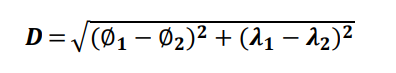

"The distance D in degrees is converted to kilometers by multiplying D by 111,319 km (1-degree earth = 69 miles ~ = 111,319 km)"

Maria, E., Budiman, E. and Taruk, M., 2020, February. Measure distance locating nearest public facilities using Haversine and Euclidean Methods. In Journal of Physics: Conference Series (Vol. 1450, No. 1, p. 012080). IOP Publishing.

In [15]:
# keep observations measured close to the ABC Weather Station (2km)
# keep locations within 2km of the weather station (-6.252349,	53.3584776)

# calculated distance
def distance(row):
  lat1 = row['latitude']
  lon1 = row['longitude']
  lat2 = 53.3584776
  lon2 = -6.252349
  distance = np.sqrt(np.power(lat1 - lat2, 2) + np.power(lon1 - lon2, 2))
  return distance

pollution['distance'] = pollution.apply(distance, axis=1)

# drop rows with distance > 2km
pollution['distance'] = (pollution['distance']* 111.319)
pollution = pollution[~(pollution['distance'] > 2)]
len(pollution)

14592

In [17]:
# exploring the FILTERED dataset
print(pollution.dtypes)
print("\nMissing values per column after fixing negative values:")
print(pollution.isnull().sum())

# get start (min) and end (max) datetime
datetime_start = pollution['datetime'].min()
datetime_end = pollution['datetime'].max()

# output start and end date with time
print(f"Start datetime: {datetime_start}")
print(f"End datetime: {datetime_end}")

print(pollution.describe())

# checking distribution by hour
pollution['hour'] = pd.to_datetime(pollution['time'], format='%H:%M:%S', errors='coerce').dt.hour
print("\nDistribution by hour:")
print(pollution['hour'].value_counts().sort_index())

# checking weekday distribution (0 = Monday, 4 = Friday)
pollution['weekday'] = pd.to_datetime(pollution['date']).dt.weekday
print("\nWeekday distribution:")
print(pollution['weekday'].value_counts().sort_index())

# NOTE: NO2_ugm3 and PM25_ugm3 has missing values.

date                 object
time                 object
datetime     datetime64[ns]
latitude            float64
longitude           float64
PM25_ugm3           float64
NO2_ugm3            float64
distance            float64
hour                  int32
weekday               int32
dtype: object

Missing values per column after fixing negative values:
date            0
time            0
datetime        0
latitude        0
longitude       0
PM25_ugm3     368
NO2_ugm3     3518
distance        0
hour            0
weekday         0
dtype: int64
Start datetime: 2021-05-07 08:09:00
End datetime: 2022-08-05 15:18:00
                            datetime      latitude     longitude  \
count                          14592  14592.000000  14592.000000   
mean   2021-12-07 22:45:41.718475776     53.354007     -6.254433   
min              2021-05-07 08:09:00     53.340575     -6.270140   
25%              2021-08-16 14:58:45     53.347336     -6.261005   
50%              2021-11-19 16:39:30     53.35

<ipython-input-17-24b9e081d13c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollution['hour'] = pd.to_datetime(pollution['time'], format='%H:%M:%S', errors='coerce').dt.hour
<ipython-input-17-24b9e081d13c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollution['weekday'] = pd.to_datetime(pollution['date']).dt.weekday


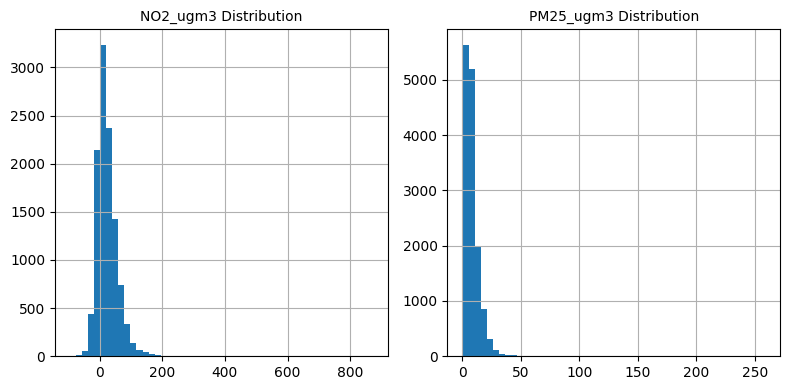

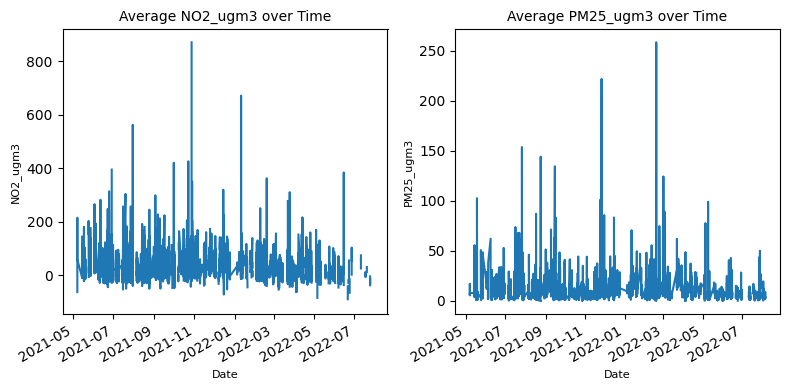


Correlation between NO2_ugm3 and PM25_ugm3:
           NO2_ugm3  PM25_ugm3
NO2_ugm3   1.000000   0.204687
PM25_ugm3  0.204687   1.000000


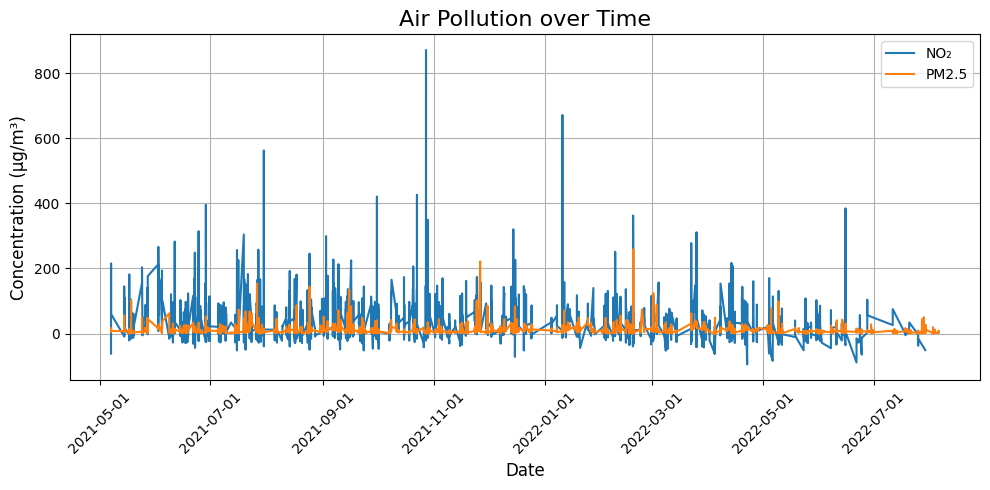

In [47]:
# plotting distribution of NO2_ugm3 and PM25_ugm3
plt.figure(figsize=(8, 4))

# NO2_ugm3 distribution
plt.subplot(1, 2, 1)
pollution['NO2_ugm3'].hist(bins=50)
plt.title('NO2_ugm3 Distribution', fontsize=10)

# PM25_ugm3 distribution
plt.subplot(1, 2, 2)
pollution['PM25_ugm3'].hist(bins=50)
plt.title('PM25_ugm3 Distribution', fontsize=10)

plt.tight_layout()
plt.show()

# trends over time for NO2_ugm3 and PM25_ugm3
plt.figure(figsize=(8, 4))

# trend for NO2_ugm3 over time
plt.subplot(1, 2, 1)
pollution.groupby('datetime')['NO2_ugm3'].mean().plot()
plt.title('Average NO2_ugm3 over Time', fontsize=10)
plt.xlabel('Date', fontsize=8)
plt.ylabel('NO2_ugm3', fontsize=8)

# trend for PM25_ugm3 over time
plt.subplot(1, 2, 2)
pollution.groupby('datetime')['PM25_ugm3'].mean().plot()
plt.title('Average PM25_ugm3 over Time', fontsize=10)
plt.xlabel('Date', fontsize=8)
plt.ylabel('PM25_ugm3', fontsize=8)

plt.tight_layout()
plt.show()

# correlation between NO2_ugm3 and PM25_ugm3
print("\nCorrelation between NO2_ugm3 and PM25_ugm3:")
print(pollution[['NO2_ugm3', 'PM25_ugm3']].corr())

# NOTE: Both pollution variables have outliers and missing values after around July 2022.

plt.figure(figsize=(10, 5))

# plot the pollution levels over time
sns.lineplot(data=pollution, x='datetime', y='NO2_ugm3', label='NO₂')
sns.lineplot(data=pollution, x='datetime', y='PM25_ugm3', label='PM2.5')

# labels and title
plt.title('Air Pollution over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Concentration (µg/m³)', fontsize=12)

# fix x-axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

# adding grid and tighten layout
plt.grid(True)
plt.tight_layout()

plt.legend()
plt.show()

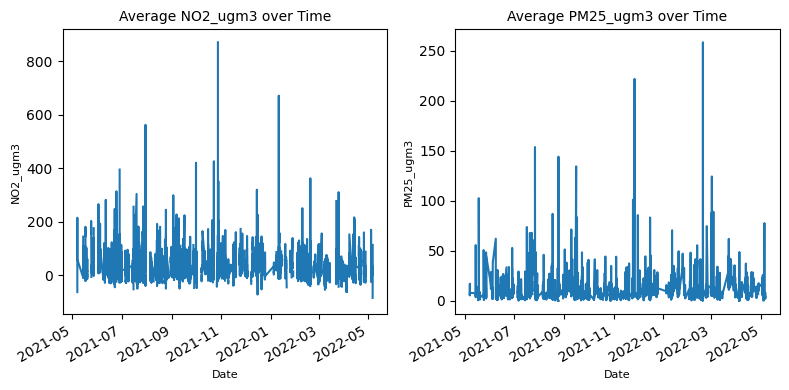


Correlation between NO2_ugm3 and PM25_ugm3:
           NO2_ugm3  PM25_ugm3
NO2_ugm3   1.000000   0.197354
PM25_ugm3  0.197354   1.000000

Number of NA rows:
date            0
time            0
datetime        0
latitude        0
longitude       0
PM25_ugm3     288
NO2_ugm3     1513
distance        0
hour            0
weekday         0
dtype: int64


In [48]:
# Leave one year data (start: 2021-05-07, end: 2022-05-07) to removing dates with large number of missing values

# one year of data
pollution_year = pollution[(pollution['datetime'] >= '2021-05-07') & (pollution['datetime'] < '2022-05-07')]
pollution_year

plt.figure(figsize=(8, 4))

# trend for NO2_ugm3 over time
plt.subplot(1, 2, 1)
pollution_year.groupby('datetime')['NO2_ugm3'].mean().plot()
plt.title('Average NO2_ugm3 over Time', fontsize=10)
plt.xlabel('Date', fontsize=8)
plt.ylabel('NO2_ugm3', fontsize=8)

# trend for PM25_ugm3 over time
plt.subplot(1, 2, 2)
pollution_year.groupby('datetime')['PM25_ugm3'].mean().plot()
plt.title('Average PM25_ugm3 over Time', fontsize=10)
plt.xlabel('Date', fontsize=8)
plt.ylabel('PM25_ugm3', fontsize=8)

plt.tight_layout()
plt.show()

# correlation
print("\nCorrelation between NO2_ugm3 and PM25_ugm3:")
print(pollution_year[['NO2_ugm3', 'PM25_ugm3']].corr())

# checking NA rows
print("\nNumber of NA rows:")
print(pollution_year.isna().sum())

In [20]:
pollution_year

,date,time,datetime,latitude,longitude,PM25_ugm3,NO2_ugm3,distance,hour,weekday
0,2022-04-07,14:56:36,2022-04-07 14:56:36,53.346434,-6.263997,4.927,11.724,1.865141,14,3
1,2022-04-07,14:57:00,2022-04-07 14:57:00,53.346570,-6.263348,3.949,NaN,1.804508,14,3
2,2022-04-07,14:58:00,2022-04-07 14:58:00,53.346699,-6.262745,7.070,16.455,1.748809,14,3
3,2022-04-07,14:59:00,2022-04-07 14:59:00,53.347005,-6.261400,5.331,13.630,1.626703,14,3
4,2022-04-07,15:00:00,2022-04-07 15:00:00,53.347569,-6.259171,4.948,24.042,1.432232,15,3
...,...,...,...,...,...,...,...,...,...,...
86403,2022-04-07,14:40:00,2022-04-07 14:40:00,53.347806,-6.266305,8.759,26.683,1.955662,14,3
86404,2022-04-07,14:41:00,2022-04-07 14:41:00,53.349881,-6.267053,4.305,32.025,1.896076,14,3
86417,2022-04-07,14:54:00,2022-04-07 14:54:00,53.346267,-6.265384,6.906,25.387,1.988247,14,3
86418,2022-04-07,14:55:00,2022-04-07 14:55:00,53.346324,-6.264813,4.615,NaN,1.937926,14,3


In [ ]:
# Import Weather Data

dataset_weather = pd.read_csv("path/to/your/WeatherData.csv")
dataset_weather

# ensure first column is datetime
dataset_weather['reportStartDateTime'] = pd.to_datetime(dataset_weather['reportStartDateTime'])

# keeping first observation of each minute
dataset_weather_clean_rows = dataset_weather[
   dataset_weather['reportStartDateTime'].dt.minute.ne(dataset_weather['reportStartDateTime'].shift().dt.minute) |
   dataset_weather['reportStartDateTime'].isna()
]
dataset_weather_clean_rows

In [26]:
# Cleaning the weather dataset

# column types
dataset_weather_clean_rows.dtypes

# create explicit copy to avoid a warning
dataset_weather_clean = dataset_weather_clean_rows.copy()

# replace 'FALSE' rainfall entries with 0
dataset_weather_clean['rainfallRate_MillimetrePerHour'] = dataset_weather_clean['rainfallRate_MillimetrePerHour'].replace('FALSE', 0)

# replace corrupted latitude codes with NA
dataset_weather_clean['latitude'] = pd.to_numeric(dataset_weather_clean['latitude'], errors='coerce')

# convert problematic columns into float64
type_conversion = {
   'rainfallRate_MillimetrePerHour': 'float64',
   'latitude': 'float64',
   'relativeHumidity': 'float64',
   'windDirection': 'float64'
}
dataset_weather_clean = dataset_weather_clean.astype(type_conversion)

# rename the cleaned dataset after processing
weather = dataset_weather_clean

# checking column types
weather.dtypes

# saving as CSV
weather.to_csv('cleaned_weather_data.csv', index=False)
weather

,reportStartDateTime,dryBulbTemperature_Celsius,windDirection,windSpeed_MetrePerSecond,relativeHumidity,rainfallAmount_Millimetre,rainfallRate_MillimetrePerHour,meanSeaLevelPressure_Hectopascal,longitude,latitude
0,2021-05-01 00:00:01+00:00,6.111111,268.0,0.715263,73.0,0.0,0.0,1017.203528,-6.252349,53.358478
1,2021-05-01 00:05:01+00:00,6.111111,337.0,0.715263,73.0,0.0,0.0,1017.101936,-6.252349,53.358478
2,2021-05-01 00:10:01+00:00,6.000000,355.0,0.312927,73.0,0.0,0.0,1017.203528,-6.252349,53.358478
3,2021-05-01 00:15:01+00:00,5.888889,0.0,0.000000,73.0,0.0,0.0,1017.203528,-6.252349,53.358478
4,2021-05-01 00:20:01+00:00,5.888889,273.0,0.312927,73.0,0.0,0.0,1017.305119,-6.252349,53.358478
...,...,...,...,...,...,...,...,...,...,...
102781,2022-08-31 23:30:00+00:00,15.611111,116.0,0.312927,84.0,0.0,0.0,1026.414506,-6.252349,53.358478
102782,2022-08-31 23:36:00+00:00,15.611111,172.0,0.312927,84.0,0.0,0.0,1026.414506,-6.252349,53.358478
102783,2022-08-31 23:42:00+00:00,15.611111,0.0,0.000000,83.0,0.0,0.0,1026.414506,-6.252349,53.358478
102784,2022-08-31 23:48:00+00:00,15.611111,90.0,0.312927,83.0,0.0,0.0,1026.414506,-6.252349,53.358478


In [30]:
# Merge two datasets by date, hour and minute

# extract date, time and hour from 'reportStartDateTime' in the weather dataset
weather['date'] = weather['reportStartDateTime'].dt.date
weather['time'] = weather['reportStartDateTime'].dt.time
weather['hour'] = weather['reportStartDateTime'].dt.hour
weather['minute'] = weather['reportStartDateTime'].dt.minute

# extract hour and minute from 'datetime' in the pollution dataset
# the 'hour' column should be extracted from pollution_year, not pollution
pollution_year.loc[:, 'hour'] = pollution_year['datetime'].dt.hour
pollution_year.loc[:, 'minute'] = pollution_year['datetime'].dt.minute

# merging the datasets on 'date', 'hour' and 'minute' (adding weather data to pollution dataset)
merged_data = pd.merge(pollution_year, weather, on=['date', 'hour', 'minute'], how='left')

# when exact minute match is not found, look for ± 6 min interval weather data

# identify rows where no exact match was found (weather data is missing)
unmatched = merged_data[merged_data['reportStartDateTime'].isna()]

# merging with ±6 minutes for rows that didn't match
for index, row in unmatched.iterrows():
    date = row['date']
    hour = row['hour']
    original_minute = row['minute']

    for delta in [-6, 6]:
        # building datetime from current row
        try:
            original_dt = datetime.combine(date, datetime.min.time()).replace(hour=hour, minute=original_minute)
        except:
            continue  # skipping invalid entries

        adjusted_dt = original_dt + timedelta(minutes=delta)

        # only proceed if still same date
        if adjusted_dt.date() != date:
            continue

        adjusted_hour = adjusted_dt.hour
        adjusted_minute = adjusted_dt.minute

        # checking if weather data exists for adjusted time
        matching_weather = weather[
            (weather['date'] == date) &
            (weather['hour'] == adjusted_hour) &
            (weather['minute'] == adjusted_minute)
        ]

        if not matching_weather.empty:
            merged_data.loc[index, weather.columns] = matching_weather.iloc[0]
            break  # stop after first match

In [31]:
# remove rows with unmatched data by minute
merged_data = merged_data[merged_data['reportStartDateTime'].notna()]
merged_data

,date,time_x,datetime,latitude_x,longitude_x,PM25_ugm3,NO2_ugm3,distance,hour,weekday,...,relativeHumidity,rainfallAmount_Millimetre,rainfallRate_MillimetrePerHour,meanSeaLevelPressure_Hectopascal,longitude_y,latitude_y,time_y,longitude,latitude,time
2,2022-04-07,14:58:00,2022-04-07 14:58:00,53.346699,-6.262745,7.070,16.455,1.748809,14,3,...,40.0,0.254,0.0,993.803580,-6.252349,53.358478,14:58:00,NaN,NaN,NaN
8,2022-04-07,15:04:00,2022-04-07 15:04:00,53.348058,-6.247543,6.525,8.551,1.277363,15,3,...,36.0,0.254,0.0,993.600396,-6.252349,53.358478,15:04:00,NaN,NaN,NaN
15,2022-04-11,10:54:00,2022-04-11 10:54:00,53.367324,-6.255395,13.520,6.896,1.041496,10,0,...,60.0,0.000,0.0,1002.811375,-6.252349,53.358478,10:54:00,NaN,NaN,NaN
21,2022-04-11,11:00:00,2022-04-11 11:00:00,53.358050,-6.265714,14.148,-4.468,1.488545,11,0,...,61.0,0.000,0.0,1002.506600,-6.252349,53.358478,11:00:01,NaN,NaN,NaN
27,2022-04-12,12:54:00,2022-04-12 12:54:00,53.346718,-6.262661,18.689,33.102,1.741083,12,1,...,81.0,7.874,0.0,1001.829322,-6.252349,53.358478,12:54:00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12122,2022-04-04,15:54:00,2022-04-04 15:54:00,53.347020,-6.249825,3.136,-6.914,1.306031,15,0,...,68.0,0.254,0.0,1012.225536,-6.252349,53.358478,15:54:00,NaN,NaN,NaN
12130,2022-04-05,09:24:00,2022-04-05 09:24:00,53.344431,-6.248999,6.440,NaN,1.607471,9,1,...,66.0,0.000,0.0,1008.398916,-6.252349,53.358478,09:24:00,NaN,NaN,NaN
12136,2022-04-07,12:22:00,2022-04-07 12:22:00,53.347444,-6.251999,7.407,13.741,1.228882,12,3,...,41.0,0.254,0.0,991.297652,-6.252349,53.358478,12:22:00,NaN,NaN,NaN
12142,2022-04-07,12:28:00,2022-04-07 12:28:00,53.347474,-6.254656,8.472,12.819,1.251493,12,3,...,40.0,0.254,0.0,991.399244,-6.252349,53.358478,12:28:00,NaN,NaN,NaN


In [32]:
# ADD TIME FACTOR - RUSH HOUR
# adding rush hour column (1 if rush hour, else 0)
merged_data.loc[:, 'rush_hour'] = merged_data['hour'].apply(lambda x: (6 <= x < 10) or (16 <= x < 19)).astype(int)
merged_data['rush_hour'].value_counts()

# Note: Rush hour margins can be changed.

,count
rush_hour,
0,3143
1,1190


In [34]:
# Define list of school holidays
school_holiday_ranges = [
    ('2021-06-30', '2021-08-31'),  # Summer 2021
    ('2021-10-25', '2021-10-29'),  # Halloween
    ('2021-12-23', '2022-01-05'),  # Christmas
    ('2022-02-21', '2022-02-25'),  # February mid-term
    ('2022-04-11', '2022-04-22'),  # Easter
    ('2022-07-01', '2022-08-31')   # Summer 2022
]

# creating a list of school holiday dates (weekdays only)
school_holidays = []
for start, end in school_holiday_ranges:
    days = pd.date_range(start=start, end=end, freq='B')  # B = business days (Mon–Fri)
    school_holidays.extend(days)

# convert to datetime and remove duplicates (if any)
school_holidays = pd.to_datetime(school_holidays).unique()
school_holidays_dt64 = pd.DatetimeIndex(school_holidays).date

# ddding school_holiday column
merged_data = merged_data.copy()
merged_data.loc[:, 'school_holiday'] = merged_data['date'].isin(school_holidays_dt64).astype(int)
merged_data['school_holiday'].value_counts()

,count
school_holiday,
0,3188
1,1145


In [35]:
merged_data.describe()

,datetime,latitude_x,longitude_x,PM25_ugm3,NO2_ugm3,distance,hour,weekday,minute,dryBulbTemperature_Celsius,...,relativeHumidity,rainfallAmount_Millimetre,rainfallRate_MillimetrePerHour,meanSeaLevelPressure_Hectopascal,longitude_y,latitude_y,longitude,latitude,rush_hour,school_holiday
count,4333,4333.000000,4333.000000,4227.000000,3866.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,...,4333.000000,4333.000000,4333.000000,4333.000000,1743.000000,1.742000e+03,2590.000000,2.588000e+03,4333.000000,4333.000000
mean,2021-10-08 19:21:46.312024320,53.353784,-6.254263,8.499709,27.531246,1.335797,12.512809,1.817217,27.491576,15.408775,...,64.020078,427.864612,0.046896,1012.192579,-6.243024,5.335848e+01,-6.239799,5.335848e+01,0.274637,0.264251
min,2021-05-07 08:10:00,53.340628,-6.270027,0.101000,-62.129000,0.070243,6.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-6.252349,5.335848e+01,-6.252349,5.335848e+01,0.000000,0.000000
25%,2021-07-19 10:45:00,53.347305,-6.260798,4.183000,4.637500,1.012274,10.000000,0.000000,15.000000,12.000000,...,57.000000,0.000000,0.000000,1010.125975,-6.252349,5.335848e+01,-6.252349,5.335848e+01,0.000000,0.000000
50%,2021-09-30 14:16:00,53.352029,-6.255083,7.045000,21.537000,1.404333,13.000000,2.000000,26.000000,15.500000,...,65.000000,0.000000,0.000000,1017.000344,-6.252349,5.335848e+01,-6.252349,5.335848e+01,0.000000,0.000000
75%,2021-12-15 15:51:00,53.359201,-6.248181,10.892000,43.217500,1.683638,15.000000,3.000000,40.000000,19.111111,...,71.000000,0.254000,0.000000,1023.908578,-6.252349,5.335848e+01,-6.252349,5.335848e+01,1.000000,1.000000
max,2022-05-06 11:22:00,53.376408,-6.234437,144.196000,562.575000,1.999790,19.000000,4.000000,58.000000,26.500000,...,95.000000,18968.720000,3.556000,1043.922137,10.000000,5.335848e+01,10.000000,5.335848e+01,1.000000,1.000000
std,NaN,0.008178,0.008181,6.773082,35.711444,0.438195,2.525518,1.482371,16.954783,4.993660,...,11.469391,2215.834256,0.229944,64.597078,0.389285,1.265129e-12,0.451541,2.856934e-12,0.446382,0.440985


The final dataset includes annual (2021-05-07 to 2022-05-06) pollution and weather data merged by minute (or +- 5 minute) within 2 km from the weather station.

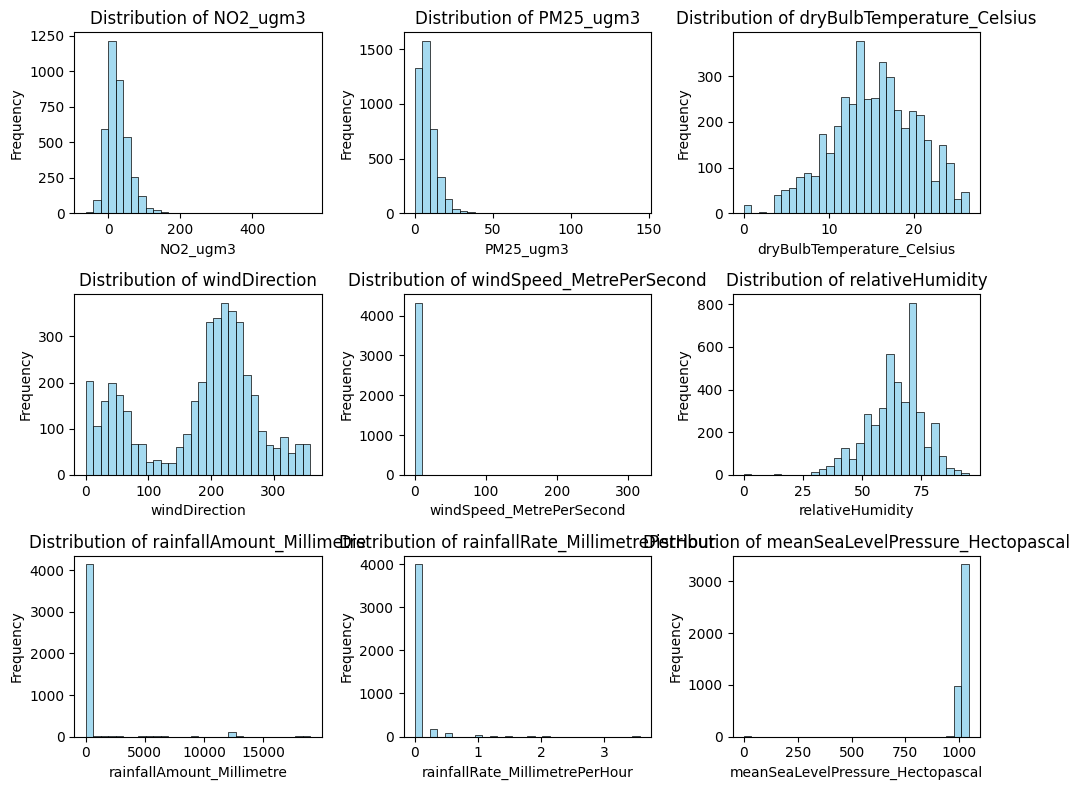

                            datetime     NO2_ugm3    PM25_ugm3      weekday  \
count                           4333  3866.000000  4227.000000  4333.000000   
mean   2021-10-08 19:21:46.312024320    27.531246     8.499709     1.817217   
min              2021-05-07 08:10:00   -62.129000     0.101000     0.000000   
25%              2021-07-19 10:45:00     4.637500     4.183000     0.000000   
50%              2021-09-30 14:16:00    21.537000     7.045000     2.000000   
75%              2021-12-15 15:51:00    43.217500    10.892000     3.000000   
max              2022-05-06 11:22:00   562.575000   144.196000     4.000000   
std                              NaN    35.711444     6.773082     1.482371   

         rush_hour  school_holiday  dryBulbTemperature_Celsius  windDirection  \
count  4333.000000     4333.000000                 4333.000000    4333.000000   
mean      0.274637        0.264251                   15.408775     180.807062   
min       0.000000        0.000000           

In [36]:
# FINAL DATASET
data = merged_data[['datetime', 'NO2_ugm3',
       'PM25_ugm3', 'weekday', 'rush_hour', 'school_holiday', 'dryBulbTemperature_Celsius', 'windDirection',
       'windSpeed_MetrePerSecond', 'relativeHumidity',
       'rainfallAmount_Millimetre', 'rainfallRate_MillimetrePerHour',
       'meanSeaLevelPressure_Hectopascal']]

# explore missing values and outliers

# variables to the plot
variables = [
    'NO2_ugm3', 'PM25_ugm3', 'dryBulbTemperature_Celsius',
    'windDirection', 'windSpeed_MetrePerSecond', 'relativeHumidity',
    'rainfallAmount_Millimetre', 'rainfallRate_MillimetrePerHour',
    'meanSeaLevelPressure_Hectopascal'
]

# size of plots
plt.figure(figsize=(10, 8))

# create a subplot grid to plot the histograms
for i, variable in enumerate(variables, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[variable], kde=False, color='skyblue', bins=30)  # Histogram without KDE
    plt.title(f'Distribution of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# describing the variables
print(data.describe())

In [37]:
data[['datetime', 'NO2_ugm3', 'PM25_ugm3', 'dryBulbTemperature_Celsius', 'rainfallAmount_Millimetre']].head()

,datetime,NO2_ugm3,PM25_ugm3,dryBulbTemperature_Celsius,rainfallAmount_Millimetre
2,2022-04-07 14:58:00,16.455,7.070,11.222222,0.254
8,2022-04-07 15:04:00,8.551,6.525,11.277778,0.254
15,2022-04-11 10:54:00,6.896,13.520,11.222222,0.000
21,2022-04-11 11:00:00,-4.468,14.148,11.000000,0.000
27,2022-04-12 12:54:00,33.102,18.689,9.611111,7.874


In [38]:
# Detection of missing values and/or outliers

# NO2: missing values
missing_no2_count = (data['NO2_ugm3'].isna().sum())
print("NO2 - Missing:", missing_no2_count)

# PM2.5: count missing values and outliers
outliers_pm25 = ((data['PM25_ugm3'].isna()) | (data['PM25_ugm3'] > 40)).sum()
print("PM2.5 - Missing or Above 40 µg/m³:", outliers_pm25)

# Mean Sea Level Pressure: count zero values
outliers_pressure_count = (data['meanSeaLevelPressure_Hectopascal'] == 0).sum()
print("Mean Sea Level Pressure - Zero values:", outliers_pressure_count)

# Rainfall Amount: count values above 100
outliers_rainfall = (data['rainfallAmount_Millimetre'] > 100).sum()
print("Rainfall Amount - Above 100 mm:", outliers_rainfall)

NO2 - Missing: 467
PM2.5 - Missing or Above 40 µg/m³: 127
Mean Sea Level Pressure - Zero values: 17
Rainfall Amount - Above 100 mm: 217


In [39]:
# drop rows with missing values and outliers - PM25
# NO2 dropped as there are too many missing

before = len(data)
print(before)

clean_data = data[
    data['PM25_ugm3'].notna() &                         # not missing
    (data['PM25_ugm3'] <= 40) &                         # not above 40
    (data['meanSeaLevelPressure_Hectopascal'] != 0) &   # not zero
    (data['rainfallAmount_Millimetre'] <= 100)          # not extreme
]

after = len(clean_data)
print(after)

clean_data.to_csv("path/to/your/Dataset.csv", index=False)

4333
3986


In [40]:
# read the final clean dataset
data = pd.read_csv("path/to/your/Dataset.csv")
len(data)

3986

In [50]:
data['datetime'] = pd.to_datetime(data['datetime'])
print(data[['PM25_ugm3', 'weekday', 'rush_hour', 'school_holiday', 'dryBulbTemperature_Celsius', 'windDirection', 'windSpeed_MetrePerSecond',
            'relativeHumidity', 'rainfallAmount_Millimetre', 'rainfallRate_MillimetrePerHour', 'meanSeaLevelPressure_Hectopascal']].corr())

                                  PM25_ugm3   weekday  rush_hour  \
PM25_ugm3                          1.000000 -0.013960   0.038969   
weekday                           -0.013960  1.000000   0.032940   
rush_hour                          0.038969  0.032940   1.000000   
school_holiday                     0.005539 -0.058996  -0.031195   
dryBulbTemperature_Celsius         0.026636 -0.150725  -0.106752   
windDirection                     -0.110066  0.080452   0.040821   
windSpeed_MetrePerSecond          -0.063532  0.212644  -0.104333   
relativeHumidity                  -0.024742  0.047262   0.156475   
rainfallAmount_Millimetre         -0.025029  0.154788   0.054164   
rainfallRate_MillimetrePerHour    -0.101477  0.116583   0.066430   
meanSeaLevelPressure_Hectopascal   0.033684 -0.170095  -0.035934   

                                  school_holiday  dryBulbTemperature_Celsius  \
PM25_ugm3                               0.005539                    0.026636   
weekday                

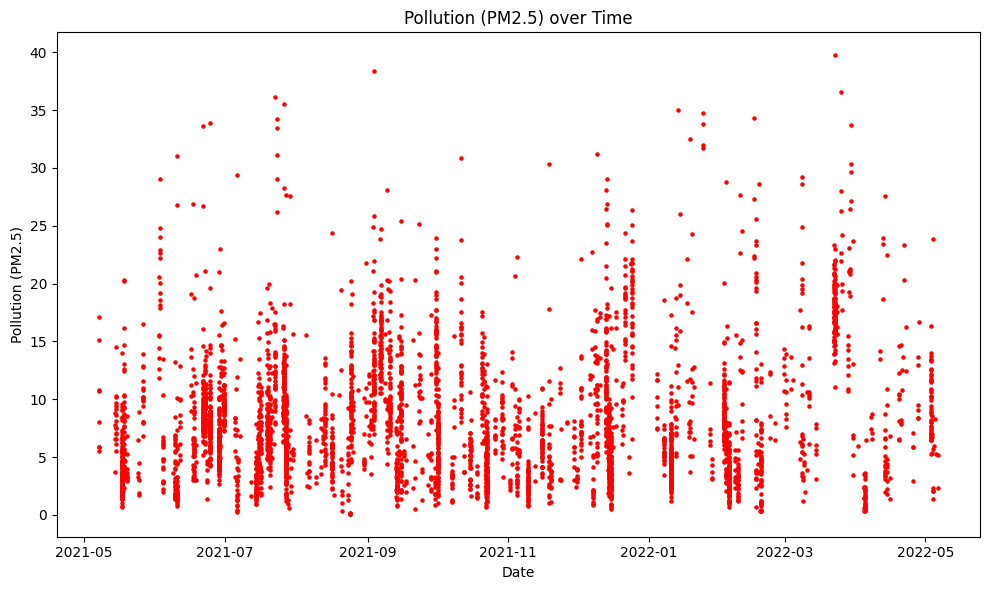

In [49]:
# visually inspect PM25_ugm3
plt.figure(figsize=(10, 6))
plt.scatter(data['datetime'], data['PM25_ugm3'], label='Pollution (PM2.5)', color='red', s=5)
plt.xlabel('Date')
plt.ylabel('Pollution (PM2.5)')
plt.title('Pollution (PM2.5) over Time')
plt.tight_layout()
plt.show()

In [44]:
# Running RANDOM FOREST

# Note:  'rainfallRate_MillimetrePerHour' was removed, it didn't chnage the model much to worse
# Note:  Sin/cos transformations of wind direction did not improve the model

# define variables
X = data[['rush_hour','school_holiday', 'weekday' , 'dryBulbTemperature_Celsius', 'windDirection', 'relativeHumidity', 'rainfallAmount_Millimetre',
          'meanSeaLevelPressure_Hectopascal']]
y = data['PM25_ugm3']

# split into test and train
X_train, X_test, y_train_array, y_test_array = train_test_split(X, y, test_size=0.2, random_state=42)

# make numpy arrays into pandas series
y_train = pd.Series(y_train_array, index=X_train.index)
y_test = pd.Series(y_test_array, index=X_test.index)

print(len(y_train))
print(len(y_test))

3188
798


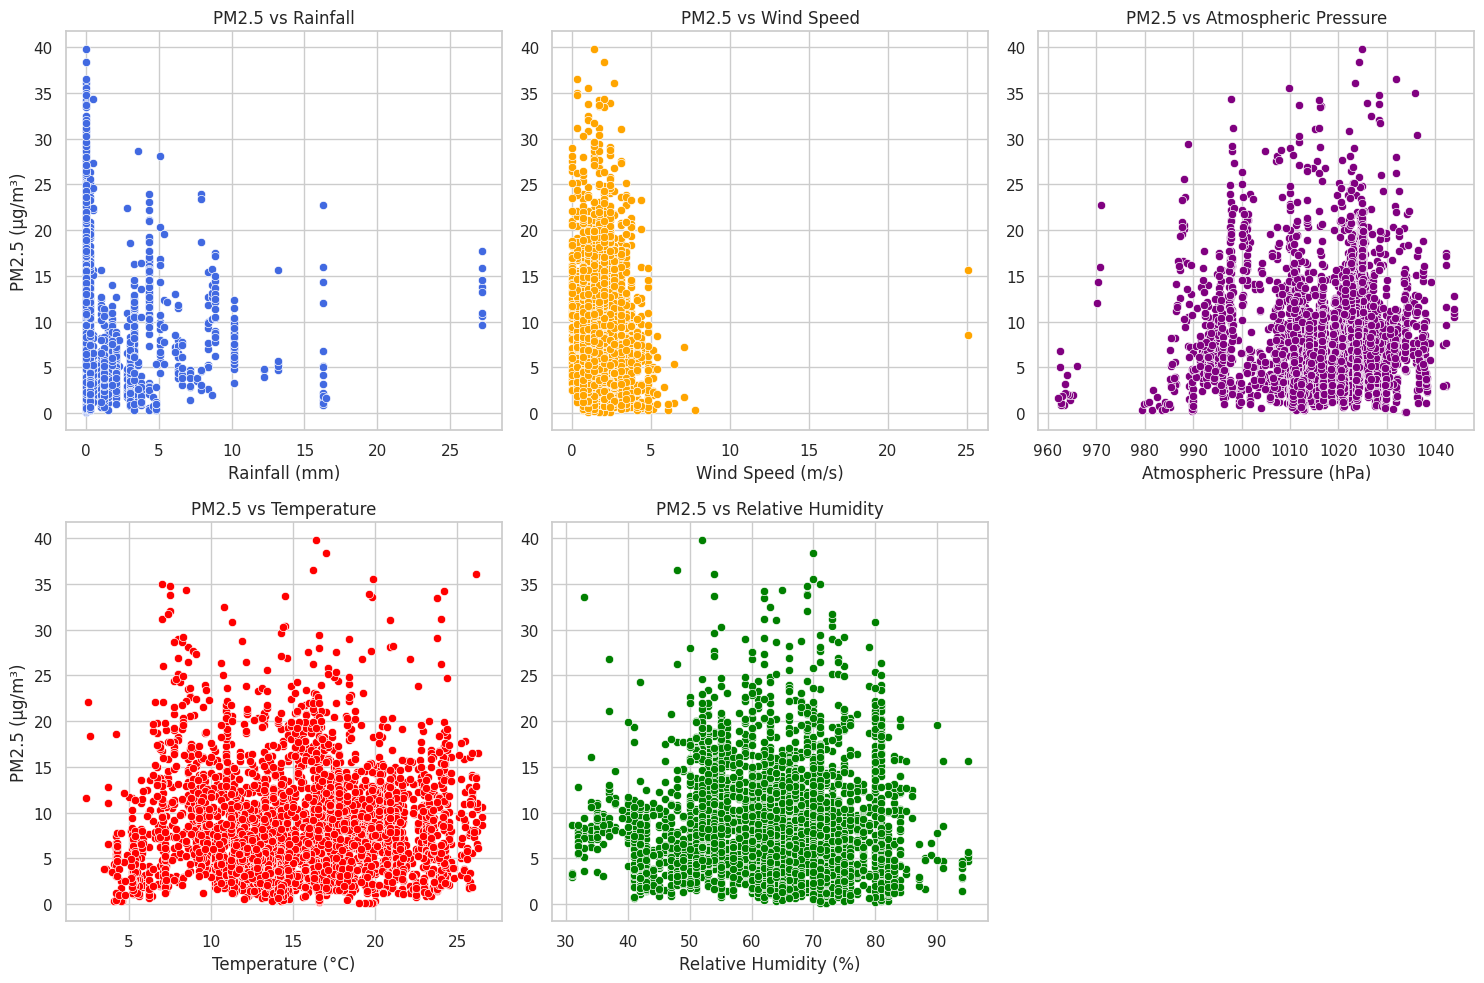

In [51]:
## PM2.5 Vs weather conditions

# set plot style
sns.set(style="whitegrid")

# figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Wider and taller

# Rainfall vs PM2.5
sns.scatterplot(data=data, x='rainfallAmount_Millimetre', y='PM25_ugm3', ax=axes[0, 0], color='royalblue')
axes[0, 0].set_title('PM2.5 vs Rainfall')
axes[0, 0].set_xlabel('Rainfall (mm)')
axes[0, 0].set_ylabel('PM2.5 (µg/m³)')

# Wind Speed vs PM2.5
sns.scatterplot(data=data, x='windSpeed_MetrePerSecond', y='PM25_ugm3', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('PM2.5 vs Wind Speed')
axes[0, 1].set_xlabel('Wind Speed (m/s)')
axes[0, 1].set_ylabel('')

# Atmospheric Pressure vs PM2.5
sns.scatterplot(data=data, x='meanSeaLevelPressure_Hectopascal', y='PM25_ugm3', ax=axes[0, 2], color='purple')
axes[0, 2].set_title('PM2.5 vs Atmospheric Pressure')
axes[0, 2].set_xlabel('Atmospheric Pressure (hPa)')
axes[0, 2].set_ylabel('')

# Temperature vs PM2.5
sns.scatterplot(data=data, x='dryBulbTemperature_Celsius', y='PM25_ugm3', ax=axes[1, 0], color='red')
axes[1, 0].set_title('PM2.5 vs Temperature')
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('PM2.5 (µg/m³)')

# Relative Humidity vs PM2.5
sns.scatterplot(data=data, x='relativeHumidity', y='PM25_ugm3', ax=axes[1, 1], color='green')
axes[1, 1].set_title('PM2.5 vs Relative Humidity')
axes[1, 1].set_xlabel('Relative Humidity (%)')
axes[1, 1].set_ylabel('')


# remove empty 6th subplot
fig.delaxes(axes[1, 2])


plt.tight_layout()
plt.show()

In [52]:
# fitting the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Rredict
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# evaluate
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r_squared = rf_model.score(X_test, y_test)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-squared:", r_squared)

MAE: 2.6031223822157648
MSE: 15.99741156779933
RMSE: 3.999676432887957
R-squared: 0.4880307362111258


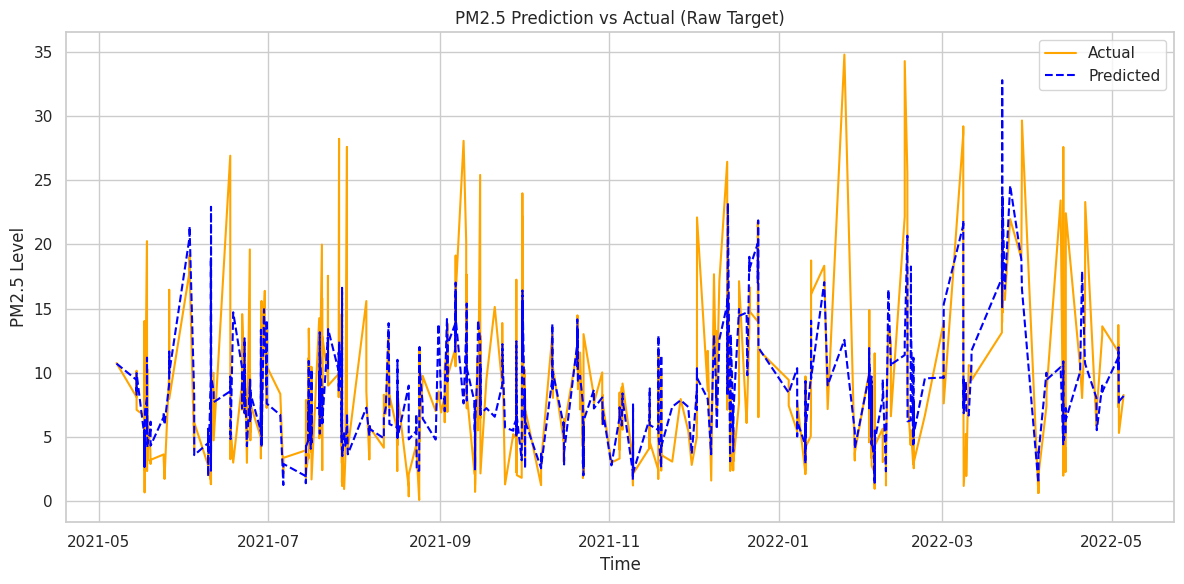

In [53]:
# convert predictions to pandas Series again
y_pred_series = pd.Series(y_test_pred, index=y_test.index, name="Predicted")

# combine actual and predicted values
results_df = pd.concat([y_test.rename("Actual"), y_pred_series], axis=1)

# adding datetime
results_df['Datetime'] = data['datetime'].reindex(results_df.index)
results_df = results_df.dropna(subset=["Datetime"])
results_df.set_index("Datetime", inplace=True)
results_df.sort_index(inplace=True)

# plotting
plt.figure(figsize=(12, 6))
plt.plot(results_df['Actual'], label='Actual', color='orange')
plt.plot(results_df['Predicted'], label='Predicted', color='blue', linestyle='--')

plt.title('PM2.5 Prediction vs Actual (Raw Target)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
# checking feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

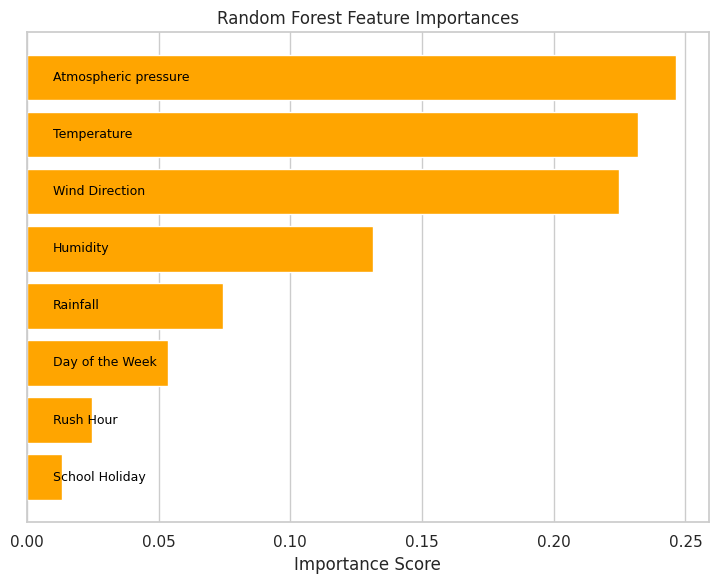

In [56]:
# plotting

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

importance_df['Feature'] = importance_df['Feature'].replace({
    'meanSeaLevelPressure_Hectopascal': 'Atmospheric pressure',
    'windDirection': 'Wind Direction',
    'dryBulbTemperature_Celsius': 'Temperature',
    'windSpeed_MetrePerSecond': 'Wind Speed',
    'relativeHumidity': 'Humidity',
    'rainfallAmount_Millimetre': 'Rainfall',
    'weekday': 'Day of the Week',
    'rush_hour': 'Rush Hour',
    'school_holiday':  'School Holiday',
})

# styled labels
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(importance_df)), importance_df['Importance'], color = "orange")



for i, bar in enumerate(bars):
    plt.text(0.01,
             bar.get_y() + bar.get_height()/2,
             f"{importance_df['Feature'].values[i]}",
             va='center', ha='left',
             color='black', fontsize=9)

# remove y-axis ticks and labels
plt.yticks([])
plt.gca().set_yticklabels([])


# titles and layout
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.subplots_adjust(left=0.30)
plt.show()